# OM x PSG - T-shirt Recognition Championship

Football (soccer) the most popular sport around the world, capable to induce many sentiments as happiness or angry. Everyone once time in your life have watched a football match. Some people can have a favorite team or not, but the fact is, football is played on the five continents and your world cup is a big party of the sport.  This sport played by 22 soccer players inside four lines became a world wide passion. On the other hand, we cannot to forget, the modern football is also a market environment with financial transactions and strategies. For many reasons football is always a present subject in our life, we found it by the TV, radio, internet, friends, neighbors and others sources. Soccer is everywhere.
 
The rivalry is another interesting feature of the soccer. In the football world we can see many rivalries developed during its long history. A derby for example is a match between two clubs knew by your rivalry.  For many football fans the derby is the most important match in the season. There are others things beyond the sport, the pride of the club and fans. Around the world the rivalries are figured between countries as Brazil x Argentine, football clubs from different cities as Barcelona x Real Madrid, clubs from the same city as Manchester United x Manchester City, but also the rivalries are present for the college, neighborhoods and friends teams. 

In France, it couldn’t be different, the rivalry is present in the hexagon. The well know “Le classique” has place every years, figured by the two of the most popular french teams, the Olympique de Marseille (OM) and the Paris Saint-Germain (PSG). The Olympique de Marseille is the most popular team in France, in your list of titles contains a Champions League, the most important competition for the football clubs in the world. In your long existence the club of the south spread across France due to your glorious history, the gold star above your logo has an important weight for the club. Despite your popularity, OM nowadays does not have a competitive team, but your supporters is the power of the club. The PSG on the other hand is the most rich french team. The club wants to entry in the hall of great teams of Europe. Always presenting good performances at international level, the PSG did never reach your main goal, became an European champion. Every year the PSG is faced with international failure. Regardless of your constant European failure, the club of the capital dominates the football at national level. 

With the objective to grow up this rivalry, in this notebook *we propose a T-shirt Recognition Championship*. **What is this competition**? This is a simple competition composed by two match, Home and Away, the team which will have more goals will be the winner. **How we measure the goals**? For this competition, we will to build two Convolution Neural Networks, one model built by hand (Home match) and  other built from a pre-trained model (Away match). To measure the model, we have some metrics as the accuracy, beyond it, we can visualize the confusion matrix, which gives us the total number of true and false positive to each class. So, from these true and false positive, we will count the number of goals for each match (Home and Away). We consider as a goal the true positive prediction (the test set is composed by 90 images, 45 for each team). The team that have more goals in the aggregate score will win the championship. The aggregate score considers the results from the both match.  **Which team will be the great winner for this funny competition**? We will soon see.

**Problem Description**

Image recognition is nowadays a successful technique with many applications to a variety of problems. The base of image recognition is the Convolutional Neural Network (CNN). The CNN is composed by some steps, as the Convolutional layer, Pooling Layer, Flatten Layer. These first steps take care about the image. As we know, an image can be represented by a matrix composed by pixels. The Convolution process generates filters for an image, these filters have a fundamental role in the learning process, because it gives many perspectives the images. The Pooling process is important to the computational process, due the fact that reduces the matrix of pixels. The Flatten process transforms the matrix of pixels into one dimensional vector, this is required to train the model. Once time the model has the images represented by vectors, we consider the Neural Network to proceed with the classification.

To build a model to realize image classification, we have two options. The first option is to build a CNN model by hand, we choose how many layers we want to the model. On the other hand, we have the option to consider a pre-trained model. This is very convenient in the case that we do not have a large dataset. A pre-trained model is trained over millions of images and reached the state of art (the model is generalized). In this project we consider the two options, we will build a model by hand (Home Match) and we will consider a pre-trained model (Away Match). The objective is to compare the efficacy of them.

**Dataset Description**

The dataset is composed by 2490 images and two class, OM and PSG. The dataset will be divided into three folders, Training Set (1200 images), Validation set (800 images) and Test set (90 images). To build a model that reach the state of art we need a large dataset. For this project the dataset is not so large, for this reason we might to obtain a over fitted model, to avoid it, there are some considerations to take account (it will be explained bellow).

The images for this project was obtained from two sources, Google research and team’s Facebook page. To the Google research the range of years considered was 2010-2021, for example, “OM maillot 2010/2011” or “PSG maillot 2015/2016”. The scraping process was done with assistance of [Download All Image extension](https://add0n.com/save-images.html).  It’s clear that this scraping method is not the most efficient, but works well (even if it takes a bit of time).

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # To build the CNN

tf.__version__

from tensorflow import keras # Calling keras
from tensorflow.keras import layers # to create the layers of neurons
from tensorflow.keras.models import Sequential # to create the Neural Network
from keras.preprocessing.image import ImageDataGenerator # Image processing

# Data Preprocessing

## Setting the training and validation set

### Image and batch size

Before build the model, we must to set the image definition as height and width. We need also to define the batch size (the number of images to be trained in a batch).

- batch size = 32
- image height = 220
- image width = 220
- image size = (220, 220)

In [2]:
batch_size = 32
img_height = 220
img_width = 220

### Training and validation set

Loading the training and validation set from a specific path using Keras image prepocessing.

In [3]:
train_set = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Training',
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1600 files belonging to 2 classes.


In [4]:
val_set = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Validation',
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 800 files belonging to 2 classes.


### Class names

To verify the name of each class.

In [5]:
class_names = train_set.class_names
print('The teams in the game:', class_names)

The teams in the game: ['OM', 'PSG']


### Visualizing the data

As we can see, each image contains a T-shirt of each french team in different scenarios. Some characteristics will be relevant to this model as the team's logo and colors. The main objective to build a CNN model consists in to obtain more information about each image by the Convolutional process, if you have a large dataset your model tends to be better. The lack of images can have a negative role during the training process leading the model to the over fit, the model memorizes but does not learn. There are some solutions to avoid this problem as we will see below.

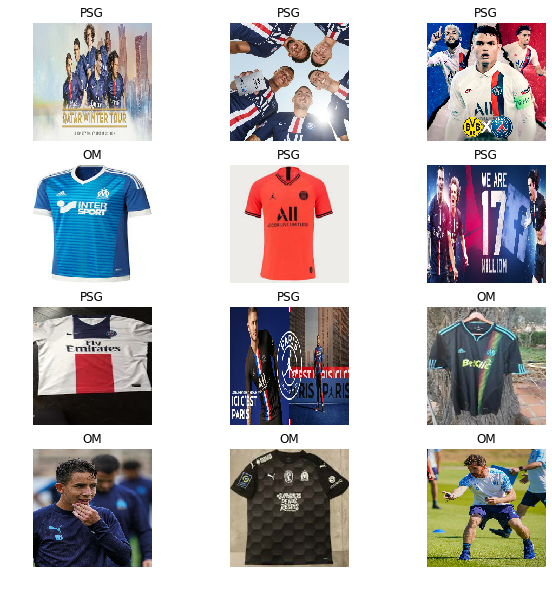

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
      for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## Setting the dataset to improve the model performance

The dataset is not larger, for this reason we need to consider some actions as the Data Augumentation (this auguments the images in many angles, it can to avoid the overfit). The Autotune aids in the computional time improving the computer perfomance. The Standardization is also required, due to the fact we build a classification model.

### Autotune

Here, we configure the dataset for a better computational performance, to know more details, [see](https://www.tensorflow.org/guide/data_performance).

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)

### Standardization of the data

The standardization of the data is a very important step to build a CNN, due to consider a classification model, we must to have the data points in the same scale. When we consider an image, the pixels values varying between 0 and 255. We want to have values between 0 and 1,  to do it, we consider the image standardization.

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) # object to rescale

### Data Augmentation

**From TensorFlow**

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [9]:
# Data augmentation with keras sequential
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.4),
    layers.experimental.preprocessing.RandomZoom(0.4),
  ]
)

# Building the CNN model

To build a Convolutional Neural Network we must to set the convolution layer, pooling layer , flatten layer and finally the full connection (the neural network to proceed with the classification model).

**Convolution** this method creates filters applying the convolution process. These filters is very useful in the learning process due to the variety of transformations, in this way the model can learn about each image in many perspectives. The number of filters and the size of receptive field must be defined.

**Pooling**  reduces the size of the matrix from the last step. There are two ways to employ it, considering the max or the mean pooling. In this model we consider the max pooling. In the pooling process we define the size of pooling kernel for example a matrix $(2,2)$, the max pooling consider the largest value. This technique gives considerable computational gains.

**Flatten** is a process that we transform the squared matrix into one dimensional array.

**Full connection** is the last step to build a CNN model. In this stage we connect the flatten vector to the first layer in the neural network to make the classification. 

## Creating the model

In [10]:
cnn_model_f = Sequential([
  data_augmentation,
  normalization_layer,
  tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  layers.Dense(units=1, activation='sigmoid')
])

**Discussing the model**

- Data augmentation and normalization layer as aforementioned provide a better data performance.
- A first convolution layer with a kernel $(3,3)$ and $128$ filters, padding in this case assures that the filters will have the same size of the input.
- A max pooling that reduces the output by $2$.
- We repeat the same convolution used before
- The max pooling will be the same after each convolution layer.
- Two convolution layers, first with $64$ filters and the last with $32$ filters.
- The flatten layer to transforms the matrix into $1D$ array.
- The neural network composed by two dense layer. After each dense layer we consider the Dropout equal to $0.5$ (to avoid over fit). The first dense layer contains $128$ neurons and the activation function is relu. The second dense layer has $64$ neurons and the same activation function.
- Finally the output dense layer with one neuron and sigmoid activation function to give the probability.

With the model summary we can see the model structure and the total of trainable parameters.

## Compiling the model

To compile the model we must to define the optimizer, the loss function and the metric to measure the model.

- Optimizer: Adam (SDG). We define also the learning rate as $0.001$.
- Loss function: Binary Cross Entropy
- Metric: Accuracy

In [11]:
base_learning_rate = 0.001
cnn_model_f.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

In [12]:
cnn_model_f.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 220, 220, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 220, 220, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 220, 220, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 64)       

## Training the model

From this moment, we are able to train the model. We need to define the number of epoch (total time that the model is trained). We can also define some callbacks as Early Stop. This technique stop the training process to avoid the over fit. To do it, we define a monitor, for example, loss function. We define also the patience, for example, if the patience is $5$, the monitor looks the five last loss function (validation set), if there is no considerable gains, the training process is interrupted (if the loss function for the validation set does not change, the model tends to the over fit if the loss function for the test set continues to increase).
- Epochs: $100$.
- Callback with loss function as monitor and patience equal to $5$.


In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
epochs = 100
history_f = cnn_model_f.fit(
  train_set,
  validation_data=val_set,
  epochs=epochs,
  callbacks = [callback]
)

Epoch 1/100
48/50 [===========================>..] - ETA: 10s - loss: 0.6869 - accuracy: 0.5360

## Learning curves (Accuracy and loss function)

The visualization of learning curves is very important to check if the model is over fitted or not. Here we present the comparison between accuracy and loss function to the training and validation set.

We have defined the number of epochs as $100$, but we also have considered the Early Stop method the number of epochs is not necessarily $100$, we check it below.

In [ ]:
# Defining the accuracy and loss function 
acc_f = history_f.history['accuracy']
val_acc_f = history_f.history['val_accuracy']

loss_f = history_f.history['loss']
val_loss_f = history_f.history['val_loss']

In [ ]:
tot_epochs = len(acc_f) # To know the number of considered epochs
print('The total of epochs :', tot_epochs)


In [ ]:
epochs_range = range(tot_epochs) # To set the limits for the plot

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.semilogx(epochs_range, acc_f, label='Training Accuracy')
plt.semilogx(epochs_range, val_acc_f, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.semilogx(epochs_range, loss_f, label='Training Loss')
plt.semilogx(epochs_range, val_loss_f, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Making predictions

Now that we have a trained model, we can proceed with the predictions. We consider $90$ images, $45$ for each equipe. We check the accuracy on the prediction set and we utilize the confusion matrix to know which team will win this home match of T-shirt recognition.

We set the prediction set with a "fake batch", in this case is the number of images that we want to predict.

### Setting the prediction set

In [ ]:
fake_batch = 90
pred_set = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Test',
  seed=0,
  image_size=(img_height, img_width),
  batch_size=fake_batch)

pred_set = pred_set.prefetch(buffer_size=AUTOTUNE) # To a better performance

### Verifying the prediction set on the trained model

In [ ]:
loss, accuracy = cnn_model_f.evaluate(pred_set) # Checking the prediction set on the trained model

### Predicting

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = pred_set.as_numpy_iterator().next()

# Apply a sigmoid since our model returns logits
predictions = cnn_model_f.predict(pred_set).flatten() # To predict
predictions = tf.where(predictions < 0.5, 0, 1) # To define the predicted class

### Metrics for the predicted results

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
cm = confusion_matrix(label_batch, predictions.numpy()) # To measure the accuracy
acc = accuracy_score(label_batch, predictions.numpy()) # To make the confusion matrix

print('Accuracy \n')
print(acc)
print('\n')
print('Confusion Matrix \n')
plt.plot()
sns.heatmap(cm, annot=True)
plt.show()
print('\n')

### Visualizing the predicted images

In [ ]:
# Visualizing the predictions and the labels
plt.figure(figsize=(15, 15))
for i in range(90):
    ax = plt.subplot(9, 10, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

## Remarks about the model and Home Match Score

The model built in this part of the project shows a good result. As we can observe, the graphics of the accuracy and loss function for the training and validation set give results that are closed. It's true that the model is not a state of art. The lack of data to train the model is a drawback during the training process, the evolution of the loss function and accuracy shows a strong variation, but the remarkable fact is, the values of these quantities is not so far in the end of the learning process, this can indicate that we do not have a model with over fit.
The predictions show also a satisfactory results, the accuracy over 50% is not bad for the number of images considered to be predicted. It’s clear, if we have more data to train, this model can be improved. For this reason, the technique of transfer learning can aid to reach a better performance, as we will soon see in this notebook.

## Home Match

In this funny competition with two of the most popular french football teams, the score for the home match is very interesting. In the CNN stadium the teams have figured a great game, the club that have started in advantage is the PSG scoring $27$ true positives prediction against $25$ for OM, it is a very close score. The away match will the define the champion. It promises great emotions because the competition is clearly opened. Which team will be the great champion?

# Build the CNN with pre-trained MobileNet V2 model

As said in the **[TensorFlow](https://www.tensorflow.org/tutorials/images/transfer_learning)** website:

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

## Setting the images, training and test set

Following the instructions by TensorFlow we set the images, training and test set as

In [ ]:
IMG_SHAPE = (160, 160) # Size of image

In [ ]:
train_set_t = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Training',
  shuffle=True,
  image_size=IMG_SHAPE,
  batch_size=batch_size) # Training set

In [ ]:
test_set_t = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Validation',
  shuffle=True,
  image_size=IMG_SHAPE,
  batch_size=batch_size) # Test set

## Downloading the base model from the **MobileNet V2**

**From TensorFlow**

The MobileNet V2 is a model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

### Downloading

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # To download

### Rescaling the images

**From TensorFlow**

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel vaues in $[-1,1]$, but at this point, the pixel values in your images are in $[0,-255]$.

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Creating the base model

**From TensorFlow**

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = IMG_SHAPE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') # Create the base model from the pre-trained model MobileNet V2

We need to convert the image size $(160x160x3)$ into $(5x5x1280)$. Here, an example to one batch of images.

In [ ]:
image_batch, label_batch = next(iter(train_set_t))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

## Feature extraction

**From TensorFlow**

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

*Freeze the convolutional base*

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Summary base model

In [ ]:
base_model.summary()

## Building the model

### Add a classification head

**From TensorFlow**

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

### The model

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compiling the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Summary model - final model

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

## Training the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_set_t)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(train_set_t,
                    epochs=initial_epochs,
                    validation_data=test_set_t,
                    callbacks=[callback])

## Learning curves (Accuracy and loss function)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Making predictions

### Setting the prediction set

In [ ]:
pred_set_t = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Test',
  shuffle=True,
  image_size=(160, 160),
  batch_size=90)
##pred_set_t = pred_set_t.prefetch(buffer_size=AUTOTUNE) # To a better performance

In [ ]:
loss, accuracy = model.evaluate(pred_set_t)
print('Test accuracy :', accuracy)

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = pred_set_t.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

#Accuracy and confusion matrix
cm_t = confusion_matrix(label_batch, predictions.numpy())
acc_t = accuracy_score(label_batch, predictions.numpy())

print('Accuracy \n')
print(acc_t)
print('\n')
print('Confusion Matrix \n')
plt.plot()
sns.heatmap(cm_t, annot=True)
plt.show()
print('\n')

### Visualizing the predicted images

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# Conclusion

